# PointNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Voici une implémentation de l'approche PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation (https://arxiv.org/abs/1612.00593) réalisée en PyTorch.

![PointNet](http://stanford.edu/~rqi/pointnet/images/teaser.jpg)

L'architecture du modèle complet est illustrée ci-dessous.
![Réseaux](http://stanford.edu/~rqi/pointnet/images/pointnet.jpg)


##  PointNet : Partie Classification
Nous allons ici nous concentrer sur la partie classification du réseau, c'est-à-dire la section qui assigne une étiquette d'appartenance à l'objet 3D fourni en entrée.




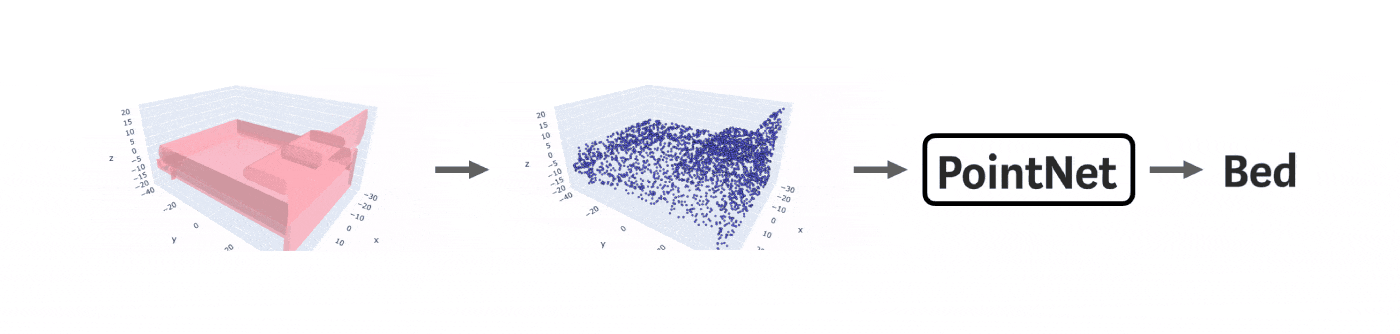


## Chargement des données

N'oubliez pas d'activer le GPU si vous souhaitez lancer l'entraînement directement.

**Exécution** -> **Modifier le type d'exécution** -> **Accélérateur matériel** -> **GPU**




In [ ]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

In [ ]:
!pip install path.py;
!pip install torchinfo

from path import Path

In [ ]:
random.seed = 42

Téléchargez le jeu de données directement dans l'environnement d'exécution de Google Colab. Il comprend 10 catégories, 3 991 modèles pour l'entraînement et 908 pour les tests.

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip;

In [ ]:
path_ModelNet10 = Path("ModelNet10")

Chaque catégorie est associée à un chiffre qui représente son label

In [ ]:
folders = [dir for dir in sorted(os.listdir(path_ModelNet10)) if os.path.isdir(path_ModelNet10/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

Ce jeu de données se compose de fichiers **.off** qui contiennent des maillages représentés par des *sommets* et des *faces triangulaires*.

Nous aurons besoin d'une fonction pour lire ce type de fichier :

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [ ]:
with open(path_ModelNet10/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

Ne vous laissez pas intimider par la fonction suivante. Elle sert simplement à afficher une rotation animée des maillages et des nuages de points.

In [ ]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )
    fig.update_layout(width=800, height=800)
    return fig

In [ ]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.80, i=i,j=j,k=k)]).show()

Ce maillage ressemble certainement à un lit. Mais en réalité ...

In [ ]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

Ce n'est pas le cas pour ses sommets. Il serait difficile pour PointNet de classifier des nuages de points comme celui-ci.

Tout d'abord, écrivons une fonction pour visualiser avec précision les nuages de points afin de mieux voir les sommets.

In [ ]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.update_layout(width=800, height=800)
    fig.show()

pcshow(x,y,z)

## Pré-traitement des données

Comme nous souhaitons qu'il ressemble davantage à un vrai lit, écrivons une fonction pour échantillonner des points uniformément sur la surface.

 ### *Sample points* : échantillonnage

In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))


    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))

        sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))

        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))

        return sampled_points


Convertissons le maillage du lit en un nuage de 3000 points.

In [ ]:
pointcloud = PointSampler(3000)((verts, faces))
pcshow(*pointcloud.T)

Ce nuage de points ressemble beaucoup plus à un lit !

### *Normalize* : noramlisation du nuage de points dans la sphère unitaire

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [ ]:
norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

Remarquez que les limites des axes ont changé.

### *Augmentations* : augmentation des données à l'aide de rotations et de bruitages aléatoires


In [ ]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])

        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [ ]:
# Rotation + Bruitage
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
pcshow(*noisy_rot_pointcloud.T)

### *ToTensor* : Conversion d'un `np.array` en tenseur

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
ToTensor()(noisy_rot_pointcloud)

## Dataset

Nous pouvons maintenant créer un [jeu de données personnalisé PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Transformations pour l'entraînement. 2048 points par nuage, comme indiqué dans l'article !

In [ ]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(2048),
                                Normalize(),
                                ToTensor()
                              ])

train_transforms = transforms.Compose([
                    PointSampler(2048),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

In [ ]:
train_ds = PointCloudData(path_ModelNet10, valid=False, folder='train', transform=train_transforms)
valid_ds = PointCloudData(path_ModelNet10, valid=True, folder='test', transform=train_transforms)

In [ ]:
# Dicitonnaire des labels
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

In [ ]:
print("Taille base d'entrainement :", len(train_ds))
print("Taille base de validation :", len(valid_ds))
print('Nombre de classes :', len(train_ds.classes))
print("Taille d'un nuage de pts échantillonné :", train_ds[0]['pointcloud'].size())
print("Obtenir la classe d'un nuage :", inv_classes[train_ds[0]['category']])

In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      # Transformation Network: convolution layers to extract features from the input
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)

      # Fully connected layers to map features to a transformation matrix of size k x k
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      # Batch normalization layers for stabilizing training
      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # Input shape (batch_size, n_points, k)
      bs = input.size(0)

      # Convolution layers with ReLU and batch normalization
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))

      # Max pooling to get the global feature vector
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)

      # Fully connected layers to output transformation matrix
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()

      # Output transformation matrix with residual addition of identity
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        # Input and feature transformation networks
        self.input_transform = ...
        self.feature_transform = ...

        # Convolution layers for feature extraction
        ...

        # Batch normalization layers
        ...

   def forward(self, input):
        # Apply input transformation to align points
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        # Feature extraction with first convolution layer
        xb = F.relu(self.bn1(self.conv1(xb)))

        # Apply feature transformation for rotation invariance
        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        # Further feature extraction
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))

        # Global feature vector via max pooling across points
        global_feature = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(global_feature)

        ################################################################
        per_point_features = [] # Variable nécessaire pour la fin du TP
        ################################################################

        return output, per_point_features, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        # Feature transformation network
        ...

        # Classification
        # Fully connected layers for classification
        ...

        # Batch normalization and dropout for regularization
        ...

        # Dropout + softmax
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
         # Transform input and extract global and per-point features
        xb, per_point_features, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))

        # Final classification layer
        output = self.fc3(xb)
        return self.logsoftmax(output), per_point_features, matrix3x3, matrix64x64

In [ ]:
from torchinfo import summary
# Create an instance of your model
model = PointNet()  # Adjust classes if needed
summary(model, input_size=(64,3,2048))

Voilà l'architecture à obtenir :

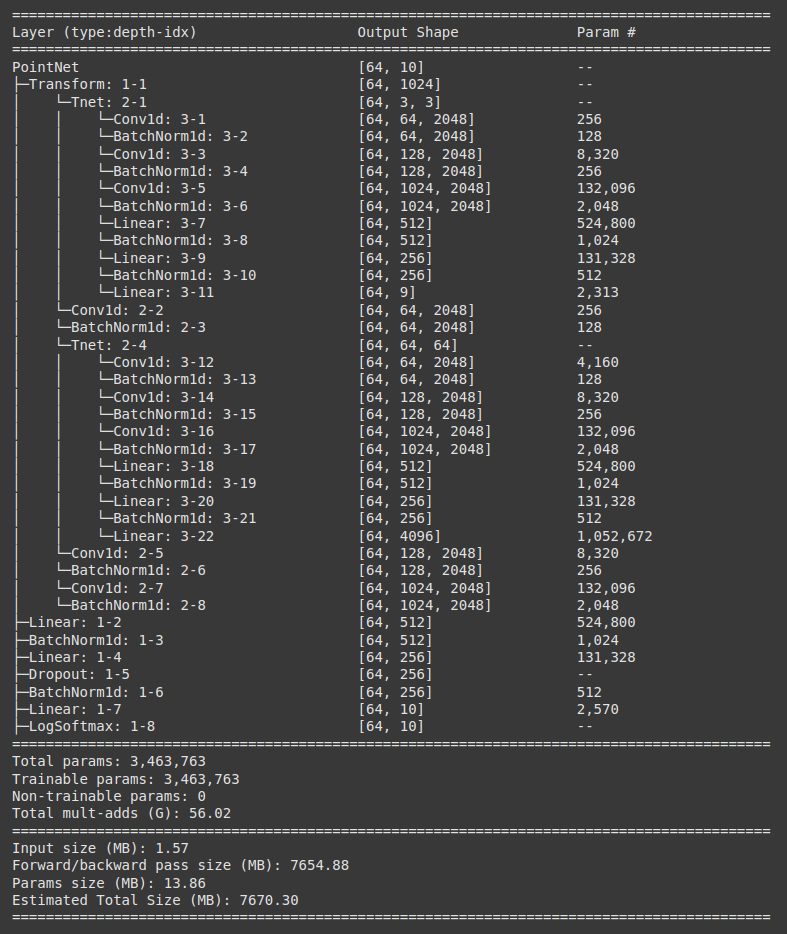

## Entrainement et test

Étant donné que l'entraînement de cette partie peut prendre du temps, nous vous fournissons déjà les points afin que vous puissiez tester les performances du classificateur.

In [ ]:
! wget https://github.com/PelissierCombescure/TP_PointNet-24-25/archive/refs/heads/main.zip -O TP_PointNet-24-25.zip
! unzip -q TP_PointNet-24-25.zip;

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('/content/TP_PointNet-24-25-main/save_PointNet_classif.pth',map_location=torch.device('cpu')))
pointnet.eval();

In [ ]:
# Prédictions
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = ...
        outputs, __, __, __ = ...
        _, preds = ...

        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Affichage de la matrice de confusion

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(all_labels, all_preds);

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Voici la matrice qu'il faut obtenir !



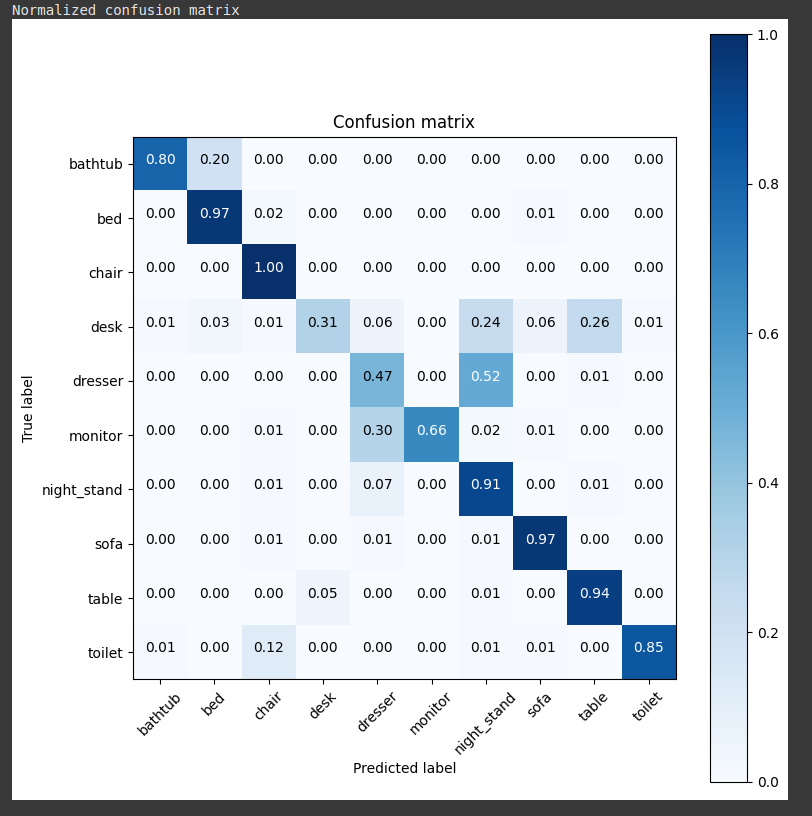

## *Critical points*

Dans l'article, les auteurs ont démontré qu'il existe, parmi l'ensemble des points échantillonnés à partir du maillage 3D en entrée, un sous-ensemble spécifique de points qui permet une classification correcte. Ces points critiques sont ceux qui présentent les réponses les plus élevées, c'est-à-dire ceux qui atteignent la valeur maximale pour chacun des 1024 "attributs" dans la matrice \( n x1024 \), obtenue avant l'application du *Max-pooling*.

/!\ Vous devez donc modifier le code associé au model PointNet pour aller récupérer cette matrice dans la variable **per_point_features** (actuellement initialisée à [ ]) !


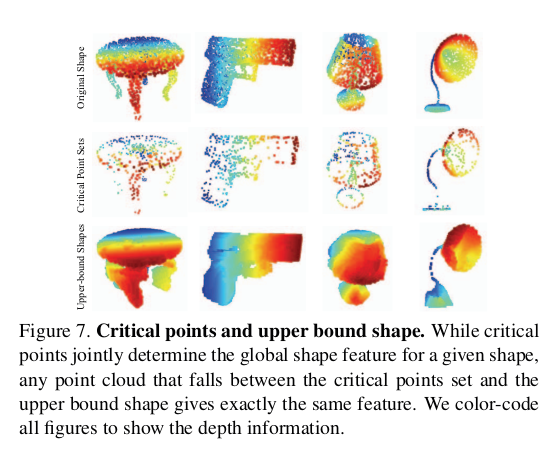

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('/content/TP_PointNet-24-25-main/save_PointNet_classif.pth', map_location=torch.device('cpu')))
pointnet.eval();

In [ ]:
#Lecture d'un maillage 3D + réalisation du pré-traitement
with open(path_ModelNet10/"chair/test/chair_0905.off", 'r') as f:
  verts, faces = read_off(f)
  ptcloud = train_transforms((verts, faces))

pcshow(*ptcloud.T)

In [ ]:
# Supposons que 'point_cloud' ait la forme [B, 3, N], où B est la taille du batch, 3 correspond aux coordonnées, et N est le nombre de points
pt_cloud_reshape = ptcloud.unsqueeze(0).float()

# Évaluation
_, per_point_features, _, _ = pointnet(pt_cloud_reshape.transpose(1, 2)); print(per_point_features.shape)

# Appliquer un max pour obtenir les indices des points critiques
_, indices = ...; print(indices.shape)

# Extraire les points critiques du nuage de points original
idx_critical_points = ...; len(idx_critical_points)

# Création du vecteur couleur
colors = []
for i in range(ptcloud.shape[0]):
    if i in idx_critical_points:
        colors.append((255,0,0))  # Rouge pour les points critiques
    else:
        colors.append((0,0,0))  # Vert pour les autres points


Dimension à obtenir :

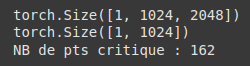

In [ ]:
import plotly.graph_objects as go

def pcshow_colors(xs, ys, zs, colors):
    """
    Parameters:
    - xs, ys, zs: Lists or arrays of x, y, and z coordinates.
    - colors: A list or array of RGB tuples (e.g., [(255, 0, 0), (0, 255, 0), ...]) for each point.
    """
    # Normalize RGB values from [0, 255] to [0, 1] if necessary
    normalized_colors = ["rgb({}, {}, {})".format(r, g, b) for r, g, b in colors]

    data = [go.Scatter3d(
        x=xs, y=ys, z=zs,
        mode='markers',
        marker=dict(size=3, color=normalized_colors)
    )]

    fig = go.Figure(data=data)
    fig.update_layout(scene=dict(aspectmode='cube'),  width=800, height=800)
    fig.show()


In [ ]:
pcshow_colors(*ptcloud.T, colors)

Voici l'ensemble de points critiques à obtenir :

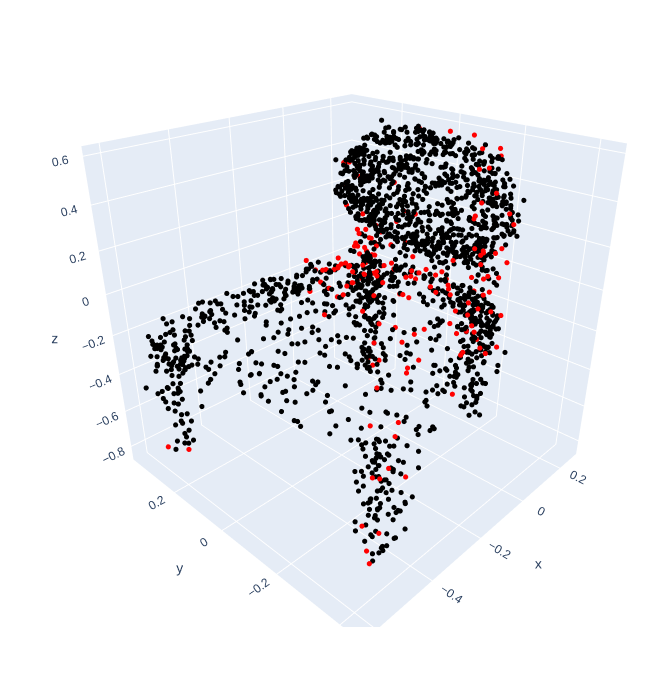